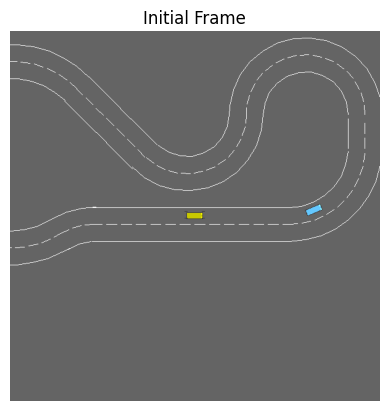

In [1]:
# Import libraries and make sure highway-env is installed properly
import highway_env
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
# pprint([env for env in gym.envs.registry.keys() if "racetrack" in env])

# Create the environment with visual rendering
env = gym.make("racetrack-v0", render_mode="rgb_array")
obs, info = env.reset()

# Render and show the first frame
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.title("Initial Frame")
plt.show()

env.close()

In [2]:
import torch
import tensorboard

print(tensorboard.__version__)
print(torch.cuda.is_available())   # Should be True
print(torch.cuda.get_device_name(0))  # Should show GPU name


2.17.1
True
NVIDIA GeForce RTX 3080


In [3]:
from stable_baselines3.common.monitor import Monitor

def make_env(render_mode=None):
    from gymnasium.wrappers import TimeLimit
    def _init():
        # config = {
        #     "action": {
        #         "type": "ContinuousAction",
        #         "lateral": False,         # Disable steering
        #         "longitudinal": True      # Enable throttle/brake
        #     }
        # }
        env = gym.make("racetrack-v0", render_mode=render_mode)
        env = TimeLimit(env, max_episode_steps=200)
        env = Monitor(env)
        return env
    return _init

In [4]:
import torch
from stable_baselines3.common.vec_env import DummyVecEnv

print(torch.cuda.is_available())   # Should be True
print(torch.cuda.get_device_name(0))  # Should show GPU name

env = DummyVecEnv([make_env(render_mode="rgb_array")])
pprint(env.envs[0].unwrapped.config)
# print the action space
print("Action Space:", env.action_space)

True
NVIDIA GeForce RTX 3080
{'action': {'lateral': True,
            'longitudinal': False,
            'target_speeds': [0, 5, 10],
            'type': 'ContinuousAction'},
 'action_reward': -0.3,
 'centering_position': [0.5, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 300,
 'lane_centering_cost': 4,
 'lane_centering_reward': 1,
 'manual_control': False,
 'observation': {'align_to_vehicle_axes': True,
                 'as_image': False,
                 'features': ['presence', 'on_road'],
                 'grid_size': [[-18, 18], [-18, 18]],
                 'grid_step': [3, 3],
                 'type': 'OccupancyGrid'},
 'offscreen_rendering': False,
 'other_vehicles': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 5,
 'real_time_rendering': False,
 'render_agent': True,
 'scaling': 5.5,
 'screen_height': 600,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15}
Action Space: Box(-1.0,

In [5]:
import os
import json
import optuna
import gymnasium as gym
import matplotlib
matplotlib.use("Agg")  # Disable interactive backend

from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from gymnasium.wrappers import TimeLimit

# Optional: mute MoviePy preview popup
preview = lambda *args, **kwargs: None

# Track best trial
best_trials = {}

def objective(trial):
    algorithm = "SAC"
    ModelClass = SAC

    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 3e-3, log=True)
    buffer_size = trial.suggest_int("buffer_size", 10_000, 60_000, log=True)
    learning_starts = trial.suggest_int("learning_starts", 1_000, 5_000)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])
    tau = trial.suggest_float("tau", 0.005, 0.02)
    gamma = trial.suggest_float("gamma", 0.90, 0.999)
    train_freq = trial.suggest_categorical("train_freq", [1, 8, 16, 64])
    gradient_steps = trial.suggest_categorical("gradient_steps", [1, 8, 16, 64])
    ent_coef = trial.suggest_categorical("ent_coef", ["auto", "auto_0.1", 1e-3, 1e-2])
    target_update_interval = trial.suggest_categorical("target_update_interval", [1, 10, 50])
    net_arch = trial.suggest_categorical("net_arch", [(64, 64), (128, 128), (256, 256)])

    # Logging
    trial_log_dir = f"racetrack/{algorithm}/optuna_run/trial_{trial.number}/"
    # video_eval_dir = os.path.join(trial_log_dir, "video_eval")
    os.makedirs(trial_log_dir, exist_ok=True)

    # Create environment
    train_env = DummyVecEnv([make_env(render_mode=None)])

    model = ModelClass(
        policy="MlpPolicy",
        env=train_env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        learning_starts=learning_starts,
        batch_size=batch_size,
        tau=tau,
        gamma=gamma,
        train_freq=train_freq,
        gradient_steps=gradient_steps,
        ent_coef=ent_coef,
        target_update_interval=target_update_interval,
        policy_kwargs=dict(net_arch=list(net_arch)),
        verbose=1,
        tensorboard_log=trial_log_dir,
    )

    # Training
    total_timesteps = 10_000
    eval_interval = 100  # Evaluate every 100 timesteps
    timesteps_run = 0


    while timesteps_run < total_timesteps:
        model.learn(
            total_timesteps=eval_interval,
            reset_num_timesteps=False,
            tb_log_name=f"{algorithm}_trial_{trial.number}",
            log_interval=1  # required to trigger logs
        )

        # Dump hyperparams to TensorBoard only once
        if timesteps_run == 0:
            for k, v in trial.params.items():
                model.logger.record(f"params/{k}", v)

        # ✅ Force log buffer to dump
        model.logger.dump(timesteps_run)

        timesteps_run += eval_interval
        print(f"Trial {trial.number}: Completed {timesteps_run} timesteps")

    # Final evaluation
    mean_reward, _ = evaluate_policy(model, train_env, n_eval_episodes=5, deterministic=True)
    train_env.close()

    best_trials[algorithm] = trial
    trial.set_user_attr("mean_reward", mean_reward)
    return mean_reward

# Run Optuna
# study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
# study.optimize(objective, n_trials=8)

# # Save best results
# out_dir = "best_hyperparams/racetrack"
# os.makedirs(out_dir, exist_ok=True)

# for algo, trial in best_trials.items():
#     print(f"\n✅ Best trial ({trial}) for {algo}:")
#     print(f"Value (Mean reward): {trial.user_attrs['mean_reward']}")
#     print("Params:", trial.params)

#     with open(os.path.join(out_dir, f"{algo}.json"), "w") as f:
#         json.dump({
#             "value": trial.user_attrs["mean_reward"],
#             "params": trial.params
#         }, f, indent=2)


In [ ]:
# import json

# algo_name = "SAC"
# ModelClass = SAC
# with open(f"best_hyperparams/racetrack/{algo_name}.json", "r") as f:
#     best_trial = json.load(f)

# params = best_trial['params']
# policy_kwargs = dict(net_arch=params.pop("net_arch"))
# # n_epochs = params.pop("num_epochs")

# from pprint import pprint
# pprint(f"Best hyperparameters for {algo_name}: {params}")
# # Create a SAC model with the best hyperparameters and train it for 20,000 timesteps
# train_env = DummyVecEnv([make_env(render_mode=None)])
# # print the action space
# pprint(train_env.envs[0].unwrapped.config)
# pprint(train_env.action_space)
# # print(train_env.envs[0].action_type.actions)


# model = ModelClass(
#     "MlpPolicy",
#     train_env,
#     verbose=1,
#     tensorboard_log=f"runs/racetrack/{algo_name}_tuned",
#     policy_kwargs=policy_kwargs,
#     # n_epochs=n_epochs,
#     **params
# )

# # Train model
# total_timesteps = 10000
# save_interval = 2000
# timesteps_run = 0
# os.makedirs("checkpoints", exist_ok=True)

# while timesteps_run < total_timesteps:
#     model.learn(
#         total_timesteps=save_interval,
#         reset_num_timesteps=False,
#         tb_log_name=f"racetrack_tuned_{algo_name}",
#         log_interval=1
#     )
#     timesteps_run += save_interval
#     model.save(f"checkpoints/racetrack_tuned_{algo_name}_{timesteps_run}")
#     print(f"✅ Saved checkpoint at {timesteps_run} timesteps")

# # Save the trained model
# model.save(f"models/{algo_name}_trained")


In [ ]:
# import modelclass
from stable_baselines3 import SAC as ModelClass

algo_name = 'SAC'
# model.save(f"models/{algo_name}_trained")
model = ModelClass.load(f"models/{algo_name}_trained")
tuned_eval_dir = f"tuned/racetrack/{algo_name}_tuned/"
video_eval_dir = os.path.join(tuned_eval_dir, "video_eval")
os.makedirs(video_eval_dir, exist_ok=True)

# Run 5 evaluation episodes and save each video
for episode in range(5):
    eval_env = DummyVecEnv([make_env(render_mode="rgb_array")])
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_eval_dir,
        record_video_trigger=lambda step: step == 0,
        video_length=200,
        name_prefix=f"tuned_sac{episode+1}"  # ✅ Unique name per video
    )

    obs = eval_env.reset()
    for _ in range(200):
        action, _ = model.predict(obs, deterministic=True)
        # print the action
        obs, _, dones, _ = eval_env.step(action)
        if dones[0]:
            break

    eval_env.close()
    print(f"🎥 Saved video for episode {episode+1}")
